In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import pickle
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam

from prediction import patches, prediction, psnr_and_ssim
from data_loader import Dataloader

In [8]:
X_train_patches, y_train_patches = pickle.load(open('train_data.pkl', 'rb'))
X_test_patches,y_test_patches = pickle.load(open('test_data.pkl', 'rb'))

In [ ]:
X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test, y_test = pickle.load(open('train_path.pkl', 'rb'))

In [23]:
# Normalization
X_train_patches = X_train_patches.astype('float32') / 255.0
y_train_patches = y_train_patches.astype('float32') / 255.0
X_test_patches = X_test_patches.astype('float32') / 255.0
y_test_patches = y_test_patches.astype('float32') / 255.0

In [25]:
batch_size = 32
train_dataloader = Dataloader(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloader(X_test_patches,y_test_patches,batch_size, shuffle=True)

# First Network: Autoencoder

In [10]:
tf.keras.backend.clear_session()

input = Input(shape=(256, 256, 3))

# Encoder
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer="he_normal", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer="he_normal", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", kernel_initializer="he_normal", padding="same")(x)
x = Conv2D(3, (3, 3), activation="sigmoid", kernel_initializer="he_normal", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [12]:
print("Num GPU Avaliable: ", len(tf.config.list_physical_devices('GPU')))

Num GPU Avaliable:  1


In [49]:
log_dir = 'logs/model_1'
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=2)
callback = [tensorboard, reducelr]

autoencoder.fit(train_dataloader, shuffle=True, epochs=20, validation_data=test_dataloader, callbacks=callback)

Epoch 1/20
4096/4096 [==============================] - 23s 5ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1.0000e-16
Epoch 2/20
4096/4096 [==============================] - 19s 5ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1.0000e-16
Epoch 3/20
4090/4096 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000830368326e-17.
4096/4096 [==============================] - 19s 5ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1.0000e-16
Epoch 4/20
4096/4096 [==============================] - 19s 5ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1.0000e-17
Epoch 5/20
4064/4096 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000664932204e-18.
4096/4096 [==============================] - 19s 5ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1.0000e-17
Epoch 6/20
4096/4096 [==============================] - 19s 5ms/step - loss: 0.0036 - val_loss: 0.0017 - lr: 1

: 

In [13]:
%tensorboard --logdir "logs/model_1"

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
autoencoder.save('models/autoencoder', save_format='tf')

In [3]:
autoencoder = tf.keras.models.load_model('models/autoencoder')

In [11]:
#sample = pd.DataFrame({'Ground Truth Images' : ['datasets/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG','datasets/SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG','datasets/SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG'], 'Noisy Images' : ['datasets/SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG','datasets/SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/NOISY_SRGB_010.PNG','datasets/SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/NOISY_SRGB_010.PNG']})
#sample = pd.DataFrame({'Ground Truth Images' : ['datasets/SIDD_Medium_Srgb/Data/0073_003_IP_00200_01000_5500_L/0073_GT_SRGB_010.PNG'], 'Noisy Images' : ['datasets/SIDD_Medium_Srgb/Data/0073_003_IP_00200_01000_5500_L/0073_NOISY_SRGB_010.PNG']})
sample = pd.DataFrame({'Ground Truth Images' : ['datasets/GT.png'], 'Noisy Images' : ['datasets/N.png']})
#sample = pd.DataFrame({'Ground Truth Images' : ['datasets/GT3.png'], 'Noisy Images' : ['datasets/N3.png']})

1/1 [==============================] - 0s 18ms/step


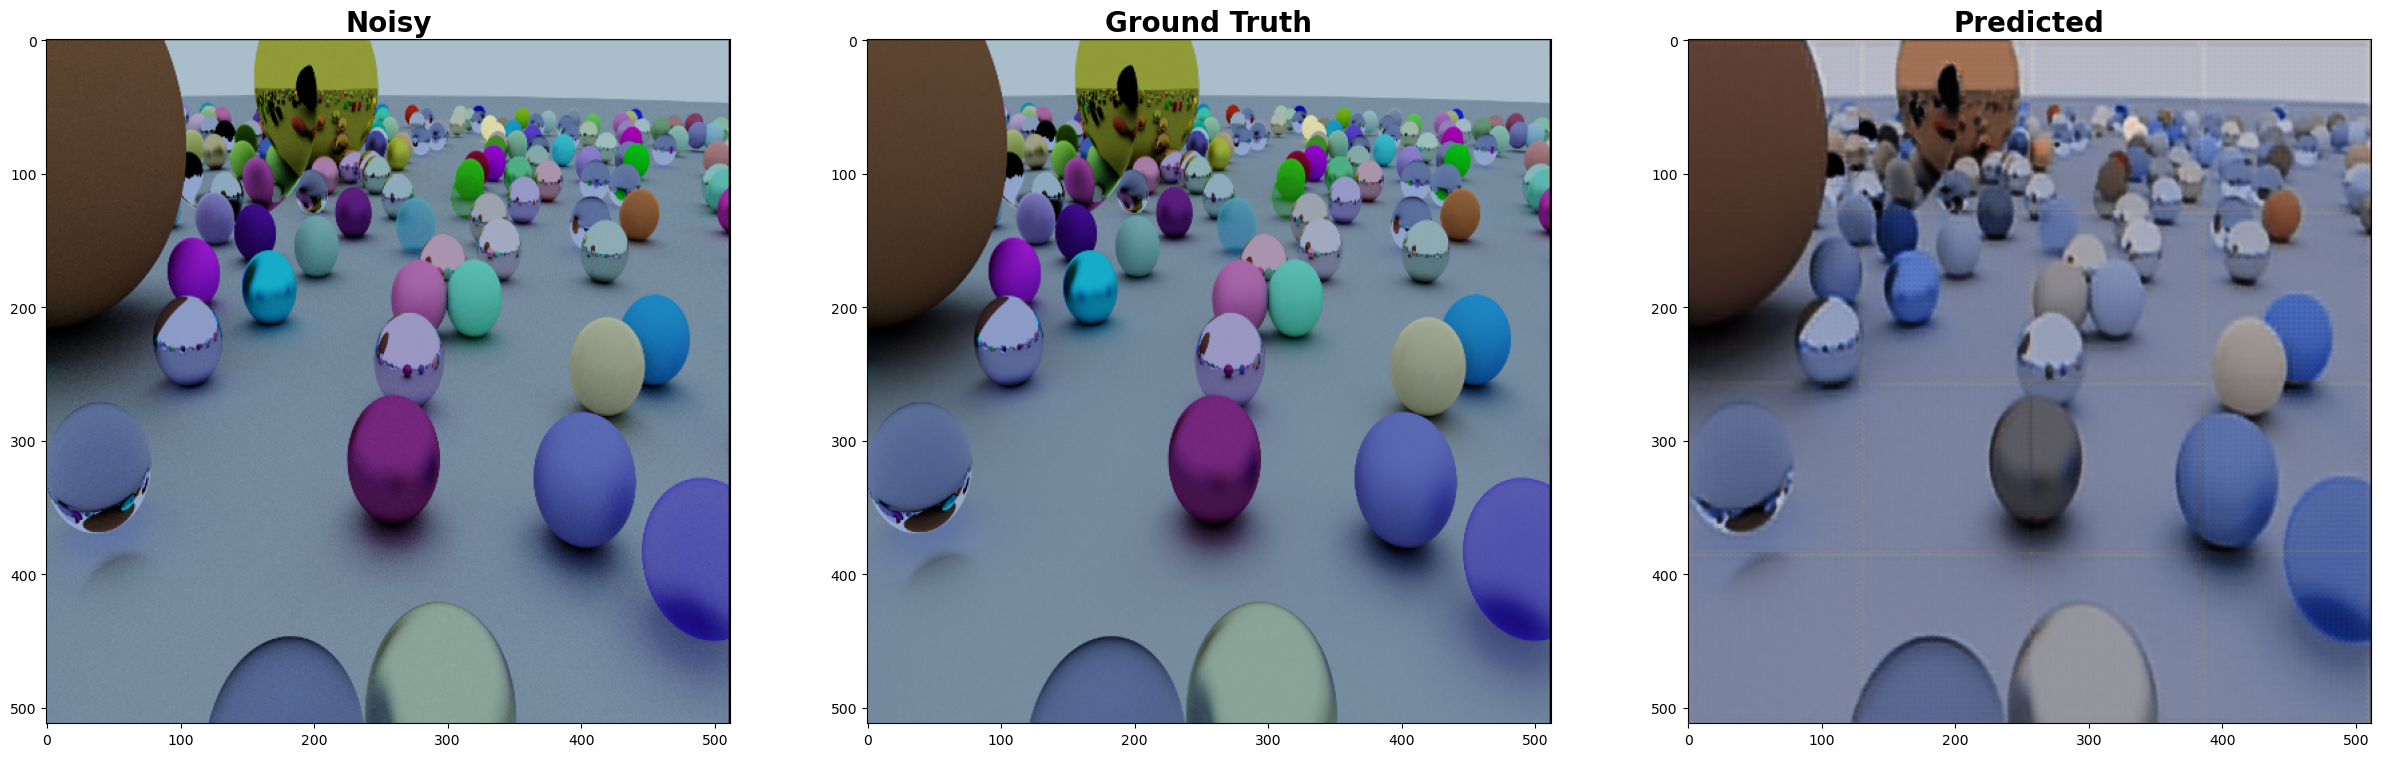

In [12]:
#visualize(sample, autoencoder)

path = sample['Ground Truth Images'].iloc[0]
test_img_gt = cv2.imread(path)
test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
test_img_gt = cv2.resize(test_img_gt, (512, 512))
test_img_gt = test_img_gt.astype("float32") / 255.0

path = sample['Noisy Images'].iloc[0]
test_img_nsy = cv2.imread(path)

pred = prediction(test_img_nsy, autoencoder)
pred = cv2.resize(pred, (512, 512))

test_img_nsy= cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
test_img_nsy = cv2.resize(test_img_nsy, (512, 512))
test_img_nsy = test_img_nsy.astype("float32") / 255.0

fig, ax = plt.subplots(1, 3, figsize=(30,30))
ax[0].imshow(test_img_nsy)
ax[0].title.set_text('Noisy')
ax[0].title.set_size(20)
ax[0].title.set_fontweight('bold')
ax[1].imshow(test_img_gt)
ax[1].title.set_text('Ground Truth')
ax[1].title.set_fontweight('bold')
ax[1].title.set_size(20)
ax[2].imshow(pred)
ax[2].title.set_text('Predicted')
ax[2].title.set_fontweight('bold')
ax[2].title.set_size(20)
plt.show()


In [33]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,autoencoder)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

1/1 [==============================] - 0s 57ms/step


C:\Users\Federico\AppData\Local\Temp\ipykernel_34296\3957550324.py:112: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
C:\Users\Federico\AppData\Local\Temp\ipykernel_34296\3957550324.py:113: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())


1/1 [==============================] - 0s 14ms/step
PSNR before denoising : 19.092841945296605
PSNR after denoising : 29.44052841544792
SSIM before denoising : 0.47035200998652726
SSIM after denoising : 0.6958600864745677
